<a href="https://colab.research.google.com/github/Kargin-Alexey/study_projects/blob/main/Sber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестовое задание Сбер, Каргин Алексей

## Python

1. В python2.7 есть ф-ции `range`, и `xrange`, в чем разница?     
Ответ: сравнение по нескольким параметрам:


 Параметр | `range` | `xrange`
--- | --- | ---
Потребление памяти| Поскольку `range()` возвращает список элементов, требуется больше памяти	|По сравнению с `range()` требует меньше памяти
Что возвращает | Она возвращает список целых чисел |	Возвращает объект-генератор
Скорость	| Скорость выполнения ниже	| Скорость выполнения выше
Операции	| Поскольку она возвращает список, можно выполнять все виды операций со списками |	Нельзя выполнять арифметические операции с `xrange()`, можно только вызывать определенные элементы списка

2. Написать на python 2 или 3 генератор первых n чисел фибоначи.    
Сигнатура: `def fibonacci_generator(n)`    
Пример использования:
```python
# вывести первые 10 чисел фибоначи
n = 10
for num in fibonacci_generator(n):
              print(num)
```

In [ ]:
import sys


def fibonacci_ganerator(n:int) -> list:
  '''Функция, возвращаюшая первые n чисел последовательности Фибоначчи
    https://ru.wikipedia.org/wiki/Числа_Фибоначчи
  '''
  if n < 1:
    sys.exit("Введите целое число больше 0") 

  fibonacci = [0, 1]
  if n in (1,2):
    return fibonacci[:n] 

  for _ in range(n-2):
    fibonacci.append(fibonacci[-1]+fibonacci[-2])
    
  return fibonacci


# вывести первые 10 чисел фибоначи
n = 10
for num in fibonacci_ganerator(n):
           print(num)


0
1
1
2
3
5
8
13
21
34


## Написать Sql-запросы


1.	Вывести отдел с наибольшим числом сотрудников;
2.	Вывести список сотрудников, получающих заработную плату выше, чем у руководителя;

__Department__

Id | name    
--- | ---    
1 |	Финансы
2	| Риски
3	| Розница
4	| Безопасность
..|	..
1000| 	ДКК

__Personal__    
id_head – id – руководителя   
id_dep – id департамента

Id | Id_head |Id_dep| name  |	sal
---|  ---    | ---  | ---   | ---
1  |	1	     |	2		|Бегинс	| 45 000
2	 | 1		   |2		  |Поттер	| 80 000
3	 |	2		   |2		  |Чапаев	| 100 000
4	 |	4		   |4		  |Шилов	| 65 000
…	 |	..	   |..		|..		  | ..
10000|	5	   |3		  |Наумов	| 64 500


```SQL
SELECT DISTINCT d.name
FROM Department as d
LEFT JOIN (
    SELECT pers.id_dep, COUNT(pers.id) as cnt
    FROM Personal as pers
    GROUP BY pers.developer_id
) as p ON d.id = p.id_dep
ORDER BY p.cnt DESC
LIMIT 1;
```

```SQL
SELECT emp.*
FROM Personal AS emp, Personal AS chief
WHERE  chief.id = emp.chief_id AND emp.salary > chief.salary
```

## Задачка на определение отрасли компании

### Постановка задачи

Необходимо собрать алгоритм, определяющий отрасль компании по её операциям.

Таблица Pays - платежи между компаниями

Столбец  | Значения
---| ---
hash_inn_kt |	Обезличенный ИНН отправителя
hash_inn_dt |	Обезличенный ИНН получателя
week |	Неделя
count	| Кол-во платежей в неделю
sum	| Сумма платежей в неделю; (обезличенная)

Таблица inn_info_public - Информация по компаниям

Столбец  | Значения
---| ---
hash_inn|	Обезличенный ИНН
okved2|	Обезличенная отрасль 
region|	Обезличенный регион 
is_public|	Флаг выборка для обучения \ контрольная

В задаче необходимо для компаний с флагом -1 в поле okved2 файла inn_info_public проставить их отрасль. (Задача много-классовой классификации)


### Импорт библиотек и загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [ ]:
! pip install catboost
! gdown --id 1F_e_ewSrquwJ210TpZtOLyH1LKpTqRTl
! unzip /content/sber_test.zip
clear_output()

In [ ]:
from catboost import CatBoostClassifier, Pool


Для возможности делиться блокнотом, загрузим данные из папки на [google drive](https://drive.google.com/file/d/1F_e_ewSrquwJ210TpZtOLyH1LKpTqRTl/view?usp=sharing)

In [ ]:
inn_types = {'hash_inn':str,	'okved2':str,'region':str,'is_public':bool}
pays_types = {'hash_inn_kt':str,'hash_inn_dt':str,'week':int,'count':int,'sum':float}
inn_info_public = pd.read_csv('inn_info_public.csv',dtype=inn_types)
pays = pd.read_csv('pays.csv',dtype=pays_types)

### Описание и обработка данных

#### Описание

Посмотрим на общий вид таблиц

In [ ]:
inn_info_public.info()
inn_info_public.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240069 entries, 0 to 240068
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   hash_inn   240069 non-null  object
 1   okved2     240069 non-null  object
 2   region     240069 non-null  object
 3   is_public  240069 non-null  bool  
dtypes: bool(1), object(3)
memory usage: 5.7+ MB


,hash_inn,okved2,region,is_public
0,61058,34,86,True
1,8311,18,86,True
2,130273,-1,86,False
3,64081,43,86,True
4,218005,12,86,True


In [ ]:
pays.info()
pays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430150 entries, 0 to 5430149
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   hash_inn_kt  object 
 1   hash_inn_dt  object 
 2   week         int64  
 3   count        int64  
 4   sum          float64
dtypes: float64(1), int64(2), object(2)
memory usage: 207.1+ MB


,hash_inn_kt,hash_inn_dt,week,count,sum
0,0,0,1,4,38399.6
1,0,0,5,2,399.6
2,0,0,7,2,79.6
3,0,0,9,2,239.6
4,0,0,12,2,79.6


In [ ]:
print('Количество дубликатов в таблице с inn:',inn_info_public.hash_inn.duplicated().sum())
print('Количество уникальных инн в таблице с платежами:',pays['hash_inn_kt'].nunique())

inn_info_train = inn_info_public.query('is_public==True').drop('is_public',axis=1).copy()
inn_info_private = inn_info_public.query('is_public==False').drop('is_public',axis=1).copy()

print(f'Размер тестовой выборки: {inn_info_train.shape[0]}\
      \nРазмер скрытой выборки: {inn_info_private.shape[0]}')

Количество дубликатов в таблице с inn: 0
Количество уникальных инн в таблице с платежами: 152160
Размер тестовой выборки: 161415      
Размер скрытой выборки: 78654


В таблице inn_info_public имеется иформация о 240069 компаниях, у 78654 компаний неизвестна отрасль, которую и необходимо определить. Это целевой признак задачи.

Также имеются данные о 5430150 операциях между компаниями, сгруппированных по неделям.

Сформулируем первоначальные гипотезы и проверим баланс классов в выборке перед обработкой данных.

#### Гипотезы

- Распределние компаний по отраслям имеет экспоненциальный вид, т.е. есть отрасли с явным преобладанием по количеству представителей.
- Есть отрасли, для которых количество/сумма платежей имеет годовую сезонность (например туризм).
- Также есть отрасли, для которых количество/сумма платежей не имеет годовую сезонность. (например розничная торговля продуктами питания)
- Количество переводов и их сумма имеет обратно пропорциональную зависимость. Средняя сумма перевода зависит от отрасли.
- Компании можно разделить на три  группы: которые в основном делают переводы, которые в основном получают переводы, которые примерно одинаково принимают и получают переводы. Компании из одной отрасли относятся к одной группе.

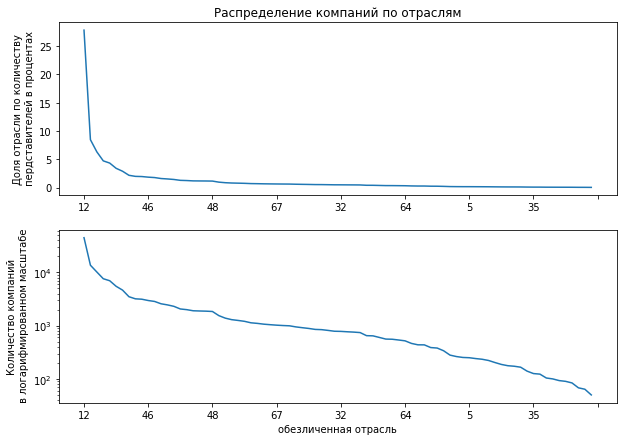

In [ ]:
plt.subplot(211)
(inn_info_train.okved2.value_counts()*100 / len(inn_info_train)).plot(figsize=(10,7))
plt.title('Распределение компаний по отраслям')
plt.ylabel('Доля отрасли по количеству\n пердставителей в процентах')

plt.subplot(212)
inn_info_train.okved2.value_counts().plot()
plt.xlabel('обезличенная отрасль')
plt.ylabel('Количество компаний\n в логарифмированном масштабе')
plt.yscale('log')
plt.show()

Гипотеза об экспоненциальном распределение компаний по отраслям подтвердилась. Дейсствительно есть отрасли, компании из которых преобладают на рынке по количеству представителей. 

Предпологая, что выборки является репрезентативными, определим один из критериев оценки модели - соотношение классов должно быть похожим для `inn_info_private` и для `inn_info_train`.

Объединим таблицы и проведем проверки остальных гипотез.

In [ ]:
data = pays.merge(inn_info_public,left_on='hash_inn_kt', right_on='hash_inn').drop('is_public',axis=1)

In [ ]:
data['sum_log'] = np.log(data['sum']+1)
data['count_log'] = np.log(data['count']+1)
data['mean_sum'] = data['sum'] / data['count']
data['mean_sum_log'] = np.log(data['mean_sum'])

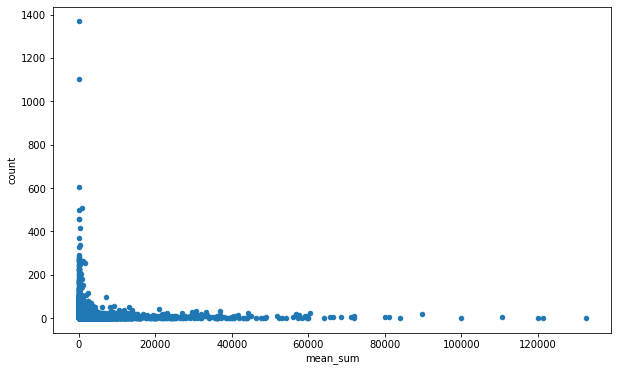

In [ ]:
data.sample(frac=0.1,random_state=12345).plot(x='mean_sum',y='count',kind='scatter')


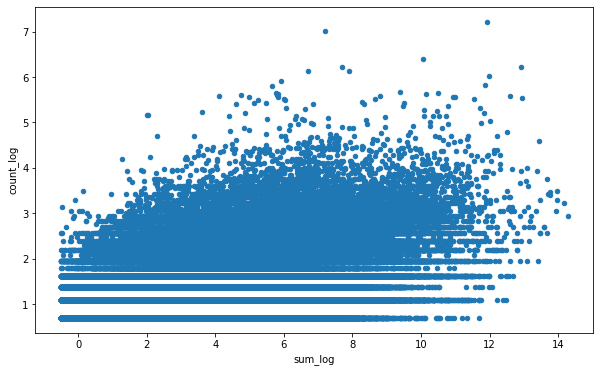

In [ ]:
data.sample(frac=0.1,random_state=12345).plot(x='sum_log',y='count_log',kind='scatter')

In [ ]:
def style_negative(v, props=''):
    return props if v < 0 else None

data.corr().style.applymap(style_negative, props='color:red')\
              .applymap(lambda v: 'opacity: 20%' if (v < 0.2) and (v > -0.2) else None)

,week,count,sum,sum_log,count_log,mean_sum,mean_sum_log
week,1.000000,0.004373,-0.000930,0.002701,0.010936,-0.001071,-0.001128
count,0.004373,1.000000,0.138059,0.263986,0.636465,0.027379,0.079975
sum,-0.000930,0.138059,1.000000,0.176029,0.112100,0.656320,0.145322
sum_log,0.002701,0.263986,0.176029,1.000000,0.440018,0.220435,0.937613
count_log,0.010936,0.636465,0.112100,0.440018,1.000000,0.041874,0.131993
mean_sum,-0.001071,0.027379,0.656320,0.220435,0.041874,1.000000,0.211061
mean_sum_log,-0.001128,0.079975,0.145322,0.937613,0.131993,0.211061,1.000000


Визуально между количеством операций и суммой операций не наблюдщается никакой зависимости даже в логарифмированном масштабе, по корреляции Пирсона есть слабая линейная зависимость между числом операций и логарифмированной суммой операций. Также есть зависимость между логарифмированным количеством операций и логарифмированной суммой операций. Это говорит о том, что нельзя эти признаки использовать вместе для ML.

Из всех представленных признаков оставим только mean_sum, count.

In [ ]:
ratio_inn = data.groupby(['hash_inn_kt'],as_index=False)['count'].sum().merge(
    data.groupby(['hash_inn_dt'],as_index=False)['count'].sum(),
    left_on='hash_inn_kt', right_on='hash_inn_dt',how='outer',suffixes=('_kt','_dt'))#.drop('hash_inn_dt', axis=1)
ratio_inn[['count_kt','count_dt']] = ratio_inn[['count_kt','count_dt']].fillna(1)
ratio_inn['ratio'] = ratio_inn['count_kt'] /  ratio_inn['count_dt']

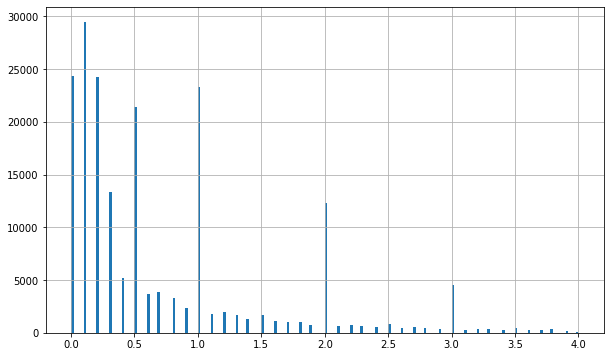

In [ ]:
ratio_inn.query('ratio < 4')['ratio'].round(1).hist(bins=200)

Разделим на три группы по отношению отправленные переводы к принятым: меньше 0.6, то 0.6 до 1.5, больше 1.5.

Есть компании, которые только принимают платежи, а есть которые только отправляют. Также добавим их в классификацию. То есть получается 5 видов компаний. 

Создадим таблицу содержащую номер группы для каждого инн. 

In [ ]:
ratio_inn.loc[ratio_inn.ratio < 0.6,'group'] = '1'
ratio_inn.loc[ratio_inn.ratio > 1.5,'group'] = '3'
ratio_inn.loc[ratio_inn.hash_inn_kt.isna() ,'group'] = '0'
ratio_inn.loc[ratio_inn.hash_inn_dt.isna() ,'group'] = '4'
ratio_inn.group = ratio_inn.group.fillna('2')

In [ ]:
ratio_inn.hash_inn_kt = ratio_inn.hash_inn_kt.fillna(ratio_inn.hash_inn_dt)

In [ ]:
ratio_inn

,hash_inn_kt,count_kt,hash_inn_dt,count_dt,ratio,group
0,0,194.0,0,1077.0,0.180130,1
1,1,14.0,NaN,1.0,14.000000,4
2,10,4.0,10,72.0,0.055556,1
3,100001,38.0,100001,26.0,1.461538,2
4,100002,4.0,NaN,1.0,4.000000,4
...,...,...,...,...,...,...
240066,99982,1.0,99982,45.0,0.022222,0
240067,99986,1.0,99986,2.0,0.500000,0
240068,99987,1.0,99987,3.0,0.333333,0
240069,99994,1.0,99994,2.0,0.500000,0


In [ ]:
grouped_inn = ratio_inn[['hash_inn_kt','group']]

In [ ]:
grouped_inn

,hash_inn_kt,group
0,0,1
1,1,4
2,10,1
3,100001,2
4,100002,4
...,...,...
240066,99982,0
240067,99986,0
240068,99987,0
240069,99994,0


Проверим гипотезы, выдвинутые по отраслям.

In [ ]:
data.week.unique()

array([ 1,  5,  7,  9, 12, 15, 16, 20, 21, 22,  3,  8, 11, 13, 14, 17,  6,
       10,  4,  2, 18, 19,  0, 23])

Проверить гипотезы по сезонности не получится, так как данные даны всего за полгода.

Рассчитаем среднее количество принятых переводов в неделю, среднее количество отправленных переводов в неделю и аналогично для средневзвешенных переводов для каждого инн.

In [ ]:
transfers_inn = data.groupby('hash_inn_kt', as_index=False)['sum','count'].sum()
transfers_inn['mean_sum_kt'] = transfers_inn['sum'] / transfers_inn['count']

transfers_inn = transfers_inn[['hash_inn_kt','mean_sum_kt']].merge(
    data.groupby('hash_inn_dt', as_index=False)['sum','count'].sum(),
    left_on='hash_inn_kt', right_on='hash_inn_dt', how='outer')

transfers_inn['mean_sum_dt'] = transfers_inn['sum'] / transfers_inn['count']

transfers_inn['hash_inn_kt'] = transfers_inn['hash_inn_kt'].fillna(transfers_inn['hash_inn_dt'])

transfers_inn = transfers_inn[['hash_inn_kt', 'mean_sum_kt', 'mean_sum_dt']].merge(
                              data.groupby('hash_inn_kt', as_index=False)['count'].mean(), how='outer')
transfers_inn = transfers_inn.merge(
                              data.groupby('hash_inn_dt', as_index=False)['count'].mean(),
                              left_on='hash_inn_kt', right_on='hash_inn_dt',
                              how='outer', suffixes=('_kt','_dt')).drop('hash_inn_dt',axis=1).fillna(0)

transfers_inn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,hash_inn_kt,mean_sum_kt,mean_sum_dt,count_kt,count_dt
0,0,1306.807155,159.727120,2.282353,2.409396
1,1,9.857143,0.000000,2.000000,0.000000
2,10,0.400000,2.119667,2.000000,2.400000
3,100001,395.284211,295.027385,2.111111,1.181818
4,100002,6.814000,0.000000,2.000000,0.000000
...,...,...,...,...,...
240066,99982,0.000000,14.638756,0.000000,1.875000
240067,99986,0.000000,5.320000,0.000000,2.000000
240068,99987,0.000000,14.117333,0.000000,1.000000
240069,99994,0.000000,6.034000,0.000000,2.000000


### Формирование признаков

Объединим все созданные таблицы с разными признаками в одну.

In [ ]:
df = inn_info_public.merge(
    transfers_inn,left_on='hash_inn', right_on='hash_inn_kt').merge(
    grouped_inn,left_on='hash_inn', right_on='hash_inn_kt').drop(['hash_inn_kt_x','hash_inn_kt_y','is_public'],axis=1)

target = df['okved2']
features = df.drop(['hash_inn','okved2'],axis=1)

In [ ]:
target_test, target_train = target[target == "-1"], target[target != "-1"]
features_test, features_train = features.loc[target_test.index], features.loc[target_train.index]

## Сборка модели

Так как стоит задача много-классовой классификации и среди признаков присутвует регион, который имеет 91 вариацию, будем исползовать модели основанные на деревьях, в частности модели библиотеки CatBoost.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345, stratify=target_train
)

categ_col = ['region','group']
train_pool = Pool(data=X_train, label=y_train,cat_features=categ_col)
test_pool = Pool(data=X_valid, label=y_valid,cat_features=categ_col)


cat_model = CatBoostClassifier(iterations=10,
                           learning_rate=0.5,
                           task_type="GPU",
                           loss_function='MultiClass', verbose=50)
cat_model.fit(train_pool, eval_set=test_pool)

In [ ]:
pd.Series(cat_model.predict(X_valid).T[0]).unique()

array(['46', '11', '27', '18', '8', '16', '5', '65', '52', '12', '33',
       '39', '6', '44', '64', '78', '7', '34', '48', '68', '15', '57',
       '55', '26', '22', '67', '29', '37', '14', '53', '43', '47', '30',
       '20', '0', '10', '56', '19', '3', '40', '70', '54', '23', '61',
       '69', '9', '72', '36', '66', '1', '17', '50', '74', '62', '32',
       '42', '45', '35', '24', '38', '4', '76', '21', '60', '79', '71',
       '2', '63', '28', '41', '58', '51', '31', '73', '13', '59', '25',
       '49', '77', '75'], dtype=object)

Модель делает предсказания только для двух классов - самых больших. Сократим количество их представителей до соотносимых с остальными размерами.

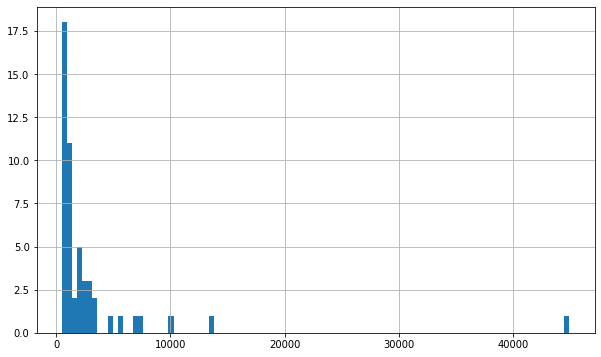

In [ ]:
target_train.value_counts()[target_train.value_counts() > 500].hist(bins=100)

Примерно уравняем количество представителей от каждой отрасли, сохранив для крупных преобладание.

In [ ]:
weights = pd.DataFrame(target_train.value_counts())
weights.loc[weights['okved2']>=15000,'weight'] = 0.06
weights.loc[(weights['okved2']>=5000) & (weights['okved2']<15000),'weight'] = 0.15
weights.loc[(weights['okved2']>=3000) & (weights['okved2']<5000),'weight'] = 0.3
weights.loc[(weights['okved2']>=2000) & (weights['okved2']<3000),'weight'] = 0.45
weights.loc[(weights['okved2']>=600) & (weights['okved2']<2000),'weight'] = 0.6
weights.loc[(weights['okved2']>=100) & (weights['okved2']<600),'weight'] = 1.7
weights.loc[(weights['okved2']<100),'weight'] = 3

weights_dict = weights['weight'].to_dict()

In [ ]:
weights.value_counts()

okved2  weight
50      3.00      1
64      3.00      1
1544    0.60      1
1385    0.60      1
1297    0.60      1
                 ..
388     1.70      1
380     1.70      1
338     1.70      1
280     1.70      1
44918   0.06      1
Length: 80, dtype: int64

In [ ]:
downsampled_target = pd.Series()
for targ in target_train.unique():
  downsampled_target = downsampled_target.append(
      target_train[target_train==targ].sample(
          frac=weights_dict[targ],
          random_state=12345,
          replace=True
          )
      )

Проверим, как соотносятся классы сейчас.

In [ ]:
downsampled_target.value_counts()

12    2695
34    2048
14    1527
8     1397
46    1336
      ... 
13     204
73     192
49     177
63     170
1      150
Length: 80, dtype: int64

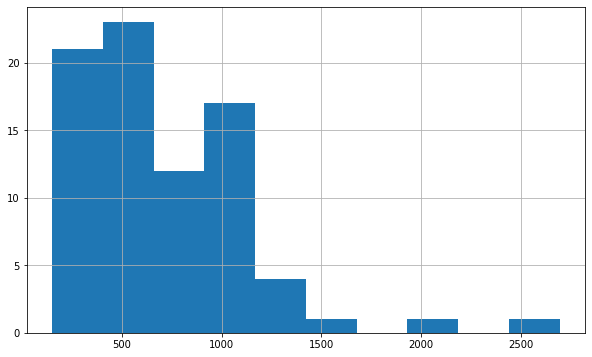

In [ ]:
downsampled_target.value_counts().hist()

Соотношение классов теперь отличается не больше, чем на порядок. Попробуем сейчас обучить модель

In [ ]:
downsampled_features = features.loc[downsampled_target.index]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    downsampled_features, downsampled_target, test_size=0.25, random_state=12345, stratify=downsampled_target
)

categ_col = ['region','group']
train_pool = Pool(data=X_train, label=y_train,cat_features=categ_col)
test_pool = Pool(data=X_valid, label=y_valid,cat_features=categ_col)


cat_model = CatBoostClassifier(iterations=600,
                           learning_rate=0.5,
                           task_type="GPU",
                           loss_function='MultiClass', verbose=100,use_best_model=True)
cat_model.fit(train_pool, eval_set=test_pool)

0:	learn: 4.1479278	test: 4.1664045	best: 4.1664045 (0)	total: 240ms	remaining: 2m 23s
100:	learn: 3.1792162	test: 3.7539677	best: 3.7539677 (100)	total: 17.4s	remaining: 1m 26s
200:	learn: 2.6085367	test: 3.6681431	best: 3.6681431 (200)	total: 35.4s	remaining: 1m 10s
300:	learn: 2.2126155	test: 3.6412040	best: 3.6407815 (299)	total: 53.1s	remaining: 52.8s
400:	learn: 1.9396426	test: 3.6289434	best: 3.6283158 (390)	total: 1m 10s	remaining: 35.1s
500:	learn: 1.7298769	test: 3.6336997	best: 3.6270122 (421)	total: 1m 34s	remaining: 18.8s
599:	learn: 1.5625948	test: 3.6403154	best: 3.6270122 (421)	total: 1m 53s	remaining: 0us
bestTest = 3.627012226
bestIteration = 421
Shrink model to first 422 iterations.


In [ ]:
pd.Series(cat_model.predict(X_valid).T[0]).nunique()

80

Модель теперь предсказывает все классы, рассчитаем качество.

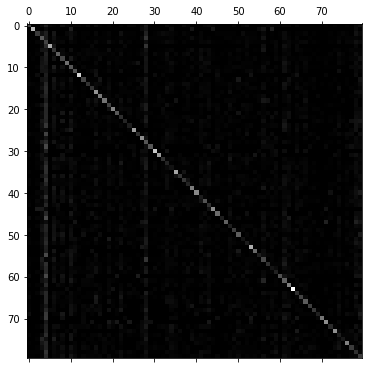

In [ ]:
conf_m = confusion_matrix(y_valid, cat_model.predict(X_valid))
norm_conf_m = conf_m / conf_m.sum(axis=1, keepdims=True)
#np.fill_diagonal(norm_conf_m, 0)
plt.matshow(norm_conf_m, cmap='gray')

По матрице рассеяния ошибки видно, что некоторые отрасли плохо классифицируются.  Также для некоторых отраслей заметно, что они часто путаются с другими. Это можно исправиться подборкой оптимальных параметров при уравнивании соотношений классов, а также подбором гиперпараметров для модели. В данной работе мы этого делать не будет, так как это требует значительных временных и вычислительных ресурсов. 

Оценим вияние признеаков.

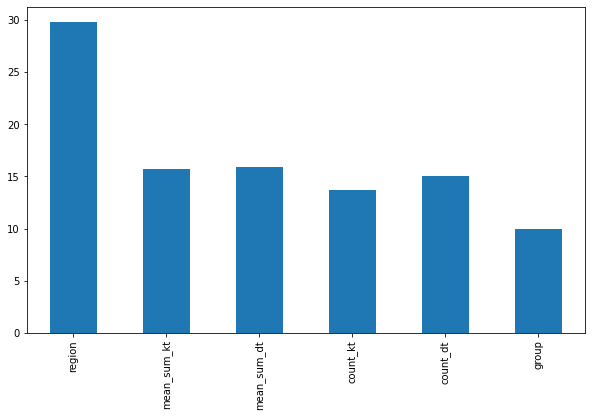

In [ ]:
pd.Series(cat_model.feature_importances_,index=X_train.columns).plot(kind='bar')

Все признаки, кроме региона, оказали примерно равно влияние на предсказание.

Определим отрасль для тестовых данных.

In [ ]:
target_train.value_counts()

12    44918
34    13654
14    10179
4      7617
52     6986
      ...  
2        90
36       84
13       68
73       64
1        50
Name: okved2, Length: 80, dtype: int64

In [ ]:
pd.Series(cat_model.predict(features_test).T[0]).value_counts()

12    9841
34    5678
14    3116
11    3011
18    2289
      ... 
13     161
63     139
77     128
72     108
1      103
Length: 80, dtype: int64

In [ ]:
roc_auc_score(target_train, cat_model.predict_proba(features_train),multi_class='ovo', average='macro')

0.4965531124727996

Качество модели по метрике `roc_auc` составило ~0.5, для констатной модели её значение было бы менее 0.25 на тестовой выборке, так как именно такую долю имеет самый большой класс. Также соотношения классов оказалось в ожидаемых нами значениях.

Сохраним предсказанные значения в базу.

In [ ]:
features_test_inn = features_test.copy()
features_test_inn['hash_inn_kt'] = df.hash_inn
features_test_inn['okved2_predict'] = cat_model.predict(features_test).T[0]

In [ ]:
inn_info_full = inn_info_public.copy()
inn_info_full.okved2 = inn_info_full.okved2.replace('-1',np.nan)
inn_info_full = inn_info_full.merge(features_test_inn[['hash_inn_kt','okved2_predict']],
                                        left_on='hash_inn', right_on='hash_inn_kt',how='outer')
inn_info_full.okved2 = inn_info_full.okved2.fillna(inn_info_full['okved2_predict'])
inn_info_full = inn_info_full.drop(['hash_inn_kt','okved2_predict'],axis=1)

In [ ]:
inn_info_full.to_csv('./inn_info_full.csv')

In [ ]:
inn_info_full

,hash_inn,okved2,region,is_public
0,61058,34,86,True
1,8311,18,86,True
2,130273,61,86,False
3,64081,43,86,True
4,218005,12,86,True
...,...,...,...,...
240064,139170,4,12,True
240065,13553,12,12,True
240066,230402,12,12,True
240067,170104,63,12,True


### Выводы


Мы проврверили ряд гипотез, по которым была разработана модель, предсказывающая  отрасль компании по данным о её банковскиъ операциях.

Некоторые выводы из данных:
- Основная масса компаний пренадлежит к 2-3 самымобширным отраслям по количеству представителей. Исходя из этого, в будущем можно улучшать текущую модель стыквкой её с другими алгоритмами, но уже выявляющих какую-то конкретную отрасль из крупных.

- В данных не найдена зависимость между средней суммой переводов и их количеством.

-Все компании можно разделить на 5 групп:только отправляют переводы; явно преобладают отправленные переводы; явно преобладают принятые переводы; принятые и полученные переводы примерно равны; только принимают переводы. 

После доработки модель может быть использована, как алгоритм, заполняющий пропуски в данных, где неизвестна отрасль компании.